# Statistics 102
This notebook is a continuation of the Statistics 101

### Getting more in-depth
The [GUSTA ME website](https://mb3is.megx.net/gustame) contains descriptions of many multivariate analyses aimed at microbial ecologists using R.

# Contents
* [Example datasets](#data)
* [PCA](#pca)
* [PCoA](#pcoa)
* [PERMANOVA](#permanova)
* [Multiple comparisons](#multiple)

In [2]:
# Load packages
library(ggplot2) # Plotting
library(phyloseq)
library(vegan) # PERMANOVA

# Example datasets<a class="anchor" id="data"></a>
**iris:** Data on plant characteristics

In [3]:
data(iris)
head(iris)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa


**phy:** Our simulated gut microbiome dataset

In [4]:
load("physeq.RData")
phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1417 taxa and 150 samples ]
sample_data() Sample Data:       [ 150 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 1417 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1417 tips and 1414 internal nodes ]
refseq()      DNAStringSet:      [ 1417 reference sequences ]

# PCA <a class="anchor" id="pca"></a>
Principle component analysis (PCA) is a way of projecting your high-dimensional data into lower dimensions. While this sounds obscure, it is extremely powerful. Imagine a dataset with 20 samples and 1000 variables (e.g. ASVs), how would you make a plot showing whether your samples are different? PCA transforms the data, and creates new axes (known as principle components (PCs)), these PCs are created such that PC1 spans as much variation as posssible in the dataset, PC2 spans as much variance as possible while being orthogonal (90 degree angle) to PC1, PC3 spans as much variance as possible while being orthogonal to PC1 and PC2, and so on.

The output from running a PCA is:
* The PCs, the new axes
* Eigenvalues for each PC, which denote how much variation each PC span
* Loadings (Eigenvectors): How much does each variable contribute to each PC

Is it confusing?:
* [Read the first answer to this Stack Exchange question](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues/140579#140579)
* [or read this excellent article](https://www.nature.com/articles/nmeth.4346)


### In R
Let's run a PCA on the plant data, plot the first two axes, and color the points by the plant species 

In [5]:
# We only use the first 4 columns
iris_sub <- iris[, 1:4]
# Always set center and scale. to TRUE
pca <- prcomp(iris_sub, center=TRUE, scale.=TRUE)

In [6]:
str(pca)
# pca$sdev contains the standard deviation of the PCs (used to calculate eigenvalues and thereby variance explained)
# pca$x contains the PCs
# pca$rotation contains loadings: How much the original variables contribute to each PCs

List of 5
 $ sdev    : num [1:4] 1.708 0.956 0.383 0.144
 $ rotation: num [1:4, 1:4] 0.521 -0.269 0.58 0.565 -0.377 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:4] "Sepal.Length" "Sepal.Width" "Petal.Length" "Petal.Width"
  .. ..$ : chr [1:4] "PC1" "PC2" "PC3" "PC4"
 $ center  : Named num [1:4] 5.84 3.06 3.76 1.2
  ..- attr(*, "names")= chr [1:4] "Sepal.Length" "Sepal.Width" "Petal.Length" "Petal.Width"
 $ scale   : Named num [1:4] 0.828 0.436 1.765 0.762
  ..- attr(*, "names")= chr [1:4] "Sepal.Length" "Sepal.Width" "Petal.Length" "Petal.Width"
 $ x       : num [1:150, 1:4] -2.26 -2.07 -2.36 -2.29 -2.38 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:4] "PC1" "PC2" "PC3" "PC4"
 - attr(*, "class")= chr "prcomp"


In [7]:
# Turn new columns into a dataframe
pc_df <- data.frame(pca$x)
# Add the species column
pc_df$Species <- iris$Species

Now the dataframe looks like this:

In [8]:
head(pc_df)

PC1,PC2,PC3,PC4,Species
-2.257141,-0.4784238,0.12727962,0.024087508,setosa
-2.074013,0.6718827,0.23382552,0.102662845,setosa
-2.356335,0.3407664,-0.04405390,0.028282305,setosa
-2.291707,0.5953999,-0.09098530,-0.065735340,setosa
-2.381863,-0.6446757,-0.01568565,-0.035802870,setosa
-2.068701,-1.4842053,-0.02687825,0.006586116,setosa


We can only get as many PCs as we have samples or variables, whichever is lowest.

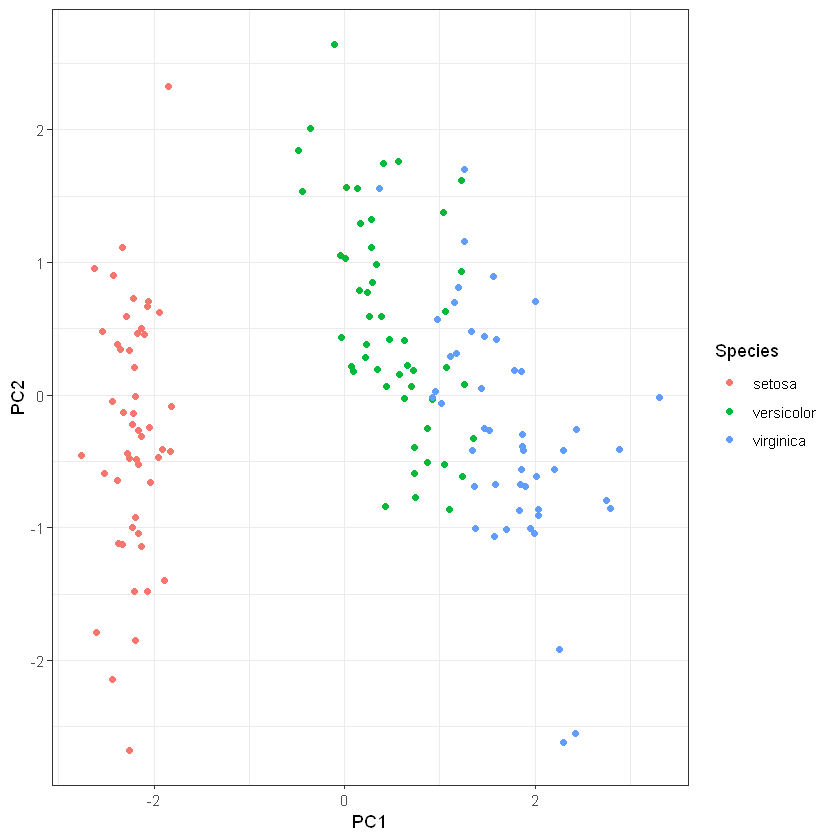

In [9]:
# Plot it
p <- ggplot(pc_df, aes(x = PC1, y = PC2, color = Species)) +
    theme_bw() +
    geom_point()
p

Let's look at which variables drive the PCs (loadings). 

In [10]:
pca$rotation

,PC1,PC2,PC3,PC4
Sepal.Length,0.5210659,-0.37741762,0.7195664,0.2612863
Sepal.Width,-0.2693474,-0.92329566,-0.2443818,-0.1235096
Petal.Length,0.5804131,-0.02449161,-0.1421264,-0.8014492
Petal.Width,0.5648565,-0.06694199,-0.6342727,0.5235971


PC1 is mostly a combination of Sepal.Length, Petal.Length, and Petal.Width. PC2 is mostly driven by Sepal.Width.

We can get the eigenvalues from the sdev:

In [11]:
eigen <- pca$sdev^2
eigen

[1] 2.91849782 0.91403047 0.14675688 0.02071484

From the eigenvalues we can get the variance explained:

In [12]:
ve <- eigen/sum(eigen)
ve

[1] 0.729624454 0.228507618 0.036689219 0.005178709

We can put this on the plot

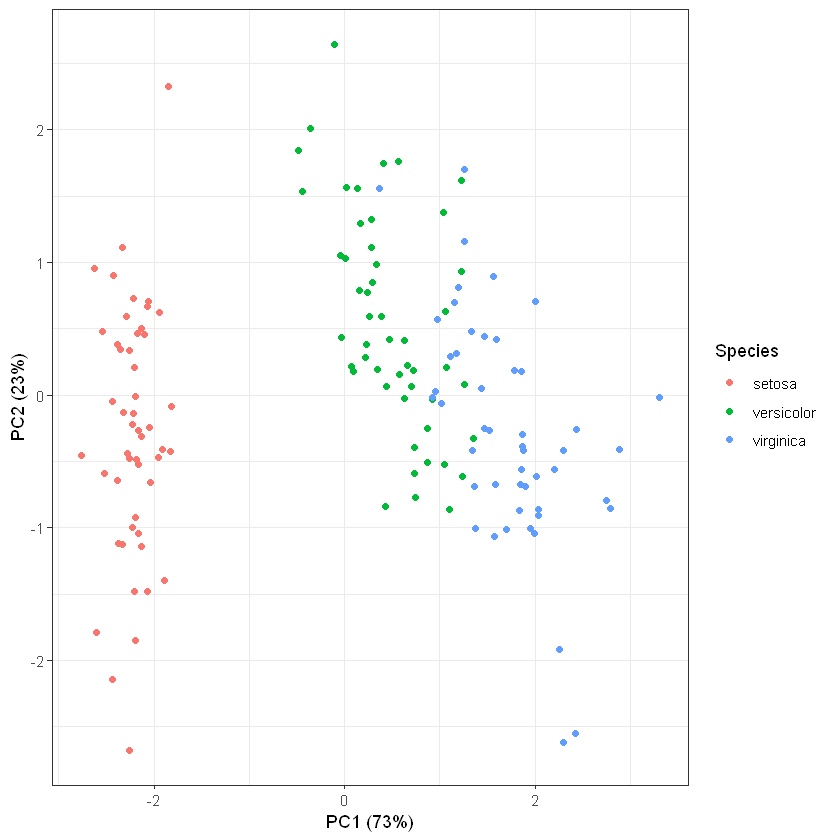

In [13]:
p + 
    xlab(paste0("PC1 (", round(100*ve[1]), "%)")) +
    ylab(paste0("PC2 (", round(100*ve[2]), "%)"))

## PCoA<a class="anchor" id="pcoa"></a>
PCA is based on linear combinations of the variables, and therefore assumes that data is not too skewed, and relatively normally distributed. Principle Coordinate Analysis (PCoA) is a generalized version of PCA. The input is a dissimilarity matrix. If this dissimilarity matrix is based on euclidean distances between samples, the PCs are the same as the PCA. The strength with PCoA is that we can use any dissimilarity metric as input. Various dissimilarity metrics appropriate for amplicon data are explained in the Beta diversity notebook.

### In R:
Let's calculate the Bray-Curtis distance between samples, and then plot a PCoA

In [14]:
library(vegan)
dd <- vegdist(iris_sub, method = "bray")

Have a look at the dissimilarity matrix (only 5 first samples). Each value is the dissimilarity between a pair of samples. The diagonal is the dissimilarity between the same samples, and is, as expected, equal to zero. 

In [15]:
as.matrix(dd)[1:5,1:5]

1,2,3,4,5
0.000000000,0.03553299,0.04081633,0.05102041,0.009803922
0.035532995,0.00000000,0.02645503,0.02645503,0.035532995
0.040816327,0.02645503,0.00000000,0.02127660,0.040816327
0.051020408,0.02645503,0.02127660,0.00000000,0.051020408
0.009803922,0.03553299,0.04081633,0.05102041,0.000000000


In [16]:
# PCoA
pcoa_data <- cmdscale(dd, eig = TRUE)

# Collect in data.frame
pcoa_df <- data.frame(PC1 = c(pcoa_data$points[,1]),
                      PC2 = c(pcoa_data$points[,2]),
                      Species = iris$Species)

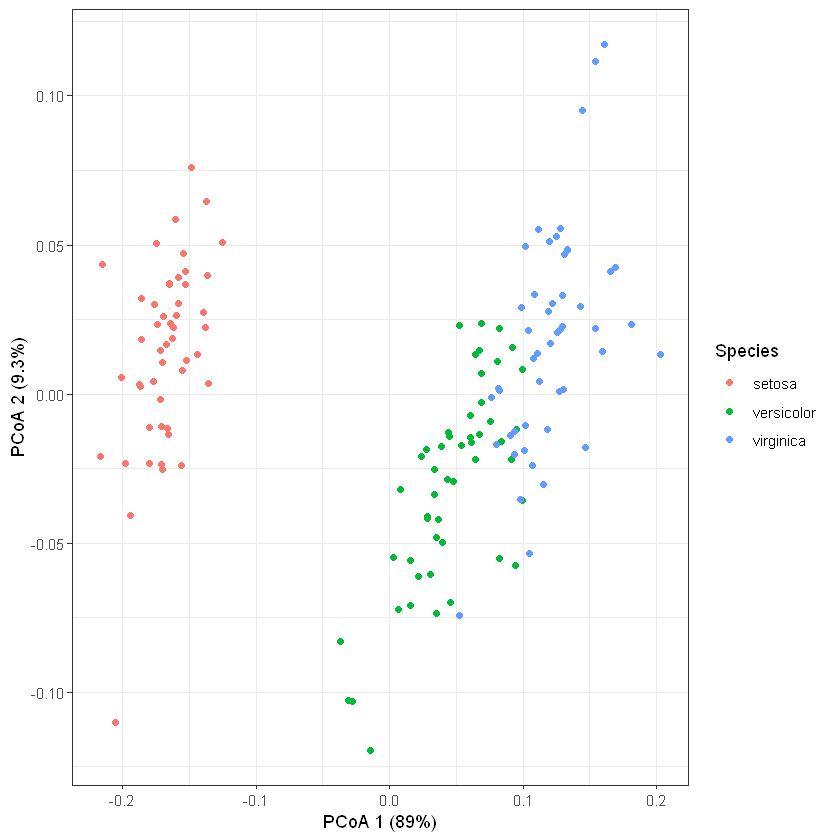

In [17]:
# Variance explained
ve <- pcoa_data$eig/sum(pcoa_data$eig)

# Plot it
p <- ggplot(pcoa_df, aes(x = PC1, y = PC2, color = Species)) +
    theme_bw() +
    geom_point() +
    xlab(paste0("PCoA 1 (",round(ve[1]*100,1),"%)")) +
    ylab(paste0("PCoA 2 (",round(ve[2]*100,1),"%)"))
p

## PERMANOVA <a class="anchor" id="permanova"></a>
PERmutational Multivariate ANalysis Of VAriance (PERMANOVA) is a method to estimate the effect a variable has on the entire microbial community. For example, for our gut microbiome dataset, we could ask whether the microbial community is different at different time points. PERMANOVA does not tell us HOW the microbial communities differ; if we want to know specifically which taxa are different between different time points we would run a Differential Abundance analysis (see notebook on this topic).

The input to PERMANOVA is a dissimilarity matrix. The results of the PERMANOVA is therefore very contingent on the dissimilarity metric that is used.

**Note:** The p-values are calculated by permutation, which is a random process, and will therefore vary a little each time you run it.

### In R:

In [18]:
# Calculate unweighted UniFrac (our dissimilarity matrix)
UF <- UniFrac(phy, weighted = FALSE)

# Extract sample data
Samp <- data.frame(sample_data(phy))

# We use the adonis function from the vegan package to run PERMANOVA
adonis(UF ~ Time, data = Samp)


Call:
adonis(formula = UF ~ Time, data = Samp) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Time        2     1.187 0.59362  1.3759 0.01838  0.001 ***
Residuals 147    63.421 0.43143         0.98162           
Total     149    64.608                 1.00000           
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

We can see that *Time* has a significant effect (P-value = 0.001) on the microbial community (as summarized by unweighted UniFrac). The variance explained (R2) by the *Time* variable is 1.8%.

#### We can add additional variables:
Here we add Delivery

In [19]:
adonis(UF ~ Time + Delivery, data = Samp)


Call:
adonis(formula = UF ~ Time + Delivery, data = Samp) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Time        2     1.187 0.59362 1.37514 0.01838  0.001 ***
Delivery    1     0.396 0.39592 0.91718 0.00613  0.804    
Residuals 146    63.025 0.43168         0.97550           
Total     149    64.608                 1.00000           
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

#### We can also add interactions between variables
For example, here we test whether the effect of Delivery changes depending on the time point, or vice versa (Time:Delivery).

In [20]:
adonis(UF ~ Time * Delivery, data = Samp)


Call:
adonis(formula = UF ~ Time * Delivery, data = Samp) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

               Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Time            2     1.187 0.59362 1.37401 0.01838  0.001 ***
Delivery        1     0.396 0.39592 0.91642 0.00613  0.788    
Time:Delivery   2     0.812 0.40603 0.93982 0.01257  0.803    
Residuals     144    62.213 0.43203         0.96293           
Total         149    64.608                 1.00000           
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

## Multiple correction<a class="anchor" id="multiple"></a>
If we wanted to know which taxa were associated with a certain variable in our dataset, we could conduct a test for each taxa, one by one, and check the p-value. All the ones with low p-values (<0.05) we would call significantly associated with our variable. The problem is that the p-value is misleading when conducting multiple statistical tests. If the Null Hypothesis is true the p-value is expected to be anywhere between 0 and 1 (uniform distribution). As such, if enough statistical tests are conducted, some (~5%) of the p-values will, by chance, be lower than 0.05, even if there are no true associations in the data. 

### Getting in-depth:
[This paper](https://www.nature.com/articles/nmeth.2900) explains the concept more in-depth for a non-statistical reader

### Simulation
Let's try to simulate some random data, and see how the p-value look like.

In [21]:
# We use the rnorm() function to generate random normally distributed data with a mean of 0 and standard deviation of 1
# Here is an example with 20 random (normallly distributed) numbers:
rnorm(20)

[1] -1.0225983  0.3343135 -1.0287059 -1.8044566 -0.5924586  0.5266992
 [7] -0.4944435  1.9091199 -0.1233572 -1.5147713  0.4402793  0.2601634
[13]  0.9020796  0.4737210 -1.2721408  0.1391032  2.4099097 -1.4982844
[19]  0.5713660  0.2790437

If we do a t-test comparing two randomlly created sets of numbers, they should not be significantly different.

In [22]:
t.test(rnorm(20), rnorm(20))


	Welch Two Sample t-test

data:  rnorm(20) and rnorm(20)
t = -0.42984, df = 37.975, p-value = 0.6697
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.6984759  0.4538160
sample estimates:
   mean of x    mean of y 
-0.120406679  0.001923246 


As expected, not significant. However, let's try to do this 10000 times, and plot a histogram of the p-values:

In [23]:
# 10000 t-tests with random data
random_ttests <- sapply(1:10000, function(x) t.test(rnorm(20), rnorm(20))$p.value)

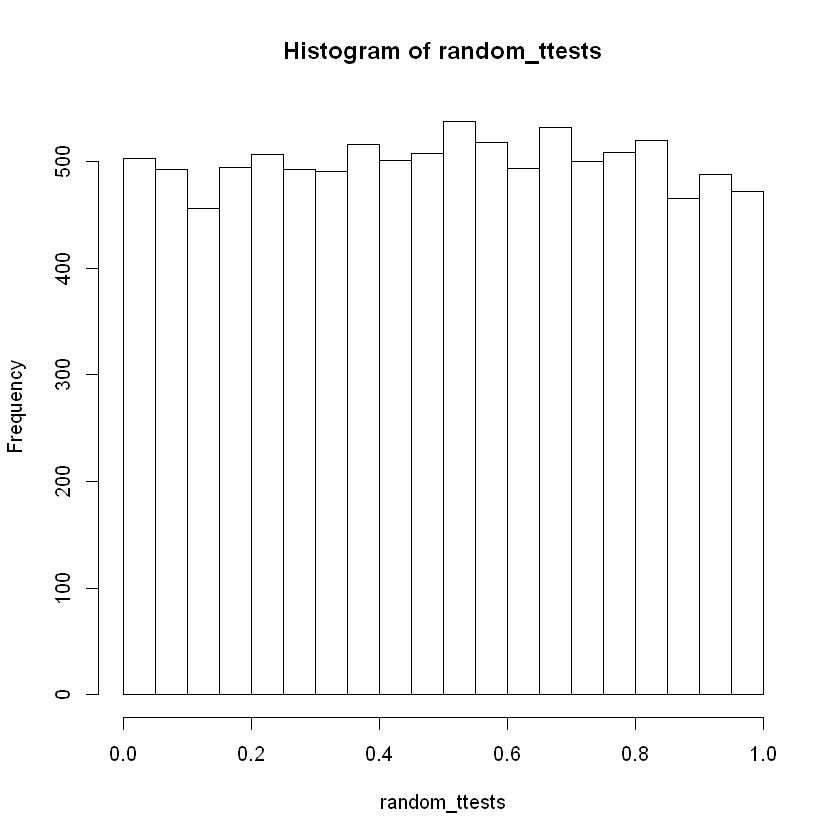

In [24]:
# Histogram
hist(random_ttests, breaks = 20)

Let's count how many of the p-values are below 0.05:

In [25]:
sum(random_ttests <= 0.05)/length(random_ttests)

[1] 0.0503

Around 5% of the p-values are lower than 0.05

### FDR correction
The most common way to adjust the p-values for this problem in the microbiome field is to use the False Discovery Rate (FDR) method developed by Benjamini and Hochberg (BH), see details on this method in the paper linked above. Assuming a cutoff of 0.05 for assigning statistical significance, then for the orginal p-values we accept a 5% chance of falsely denoting **a single test** significant even though it is not. With the FDR we accept that 5% of **all the tests we call significant** are not truely significant. The difference is subtle, but crucial.

#### In R:

In [26]:
adjusted_pvals <- p.adjust(random_ttests, method = "BH")

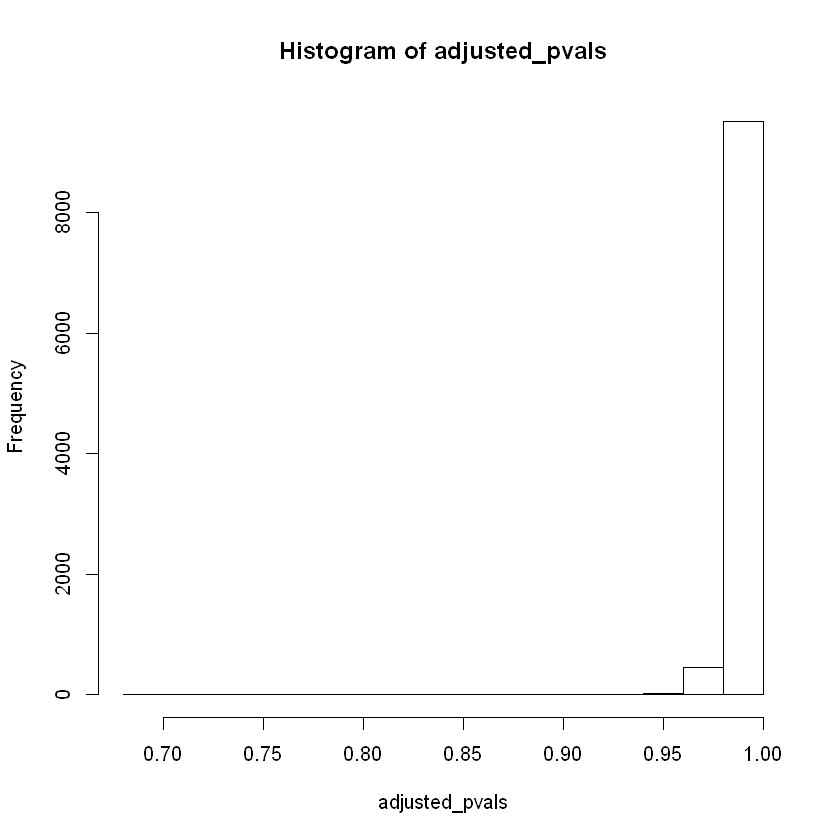

In [27]:
# Histogram
hist(adjusted_pvals)

All adjusted p-values are close to 1 (not significant)

##### Let's try to add a single t-test which should be significant and check if it is still significant after adjustment

In [28]:
# Low p-value
ttest_sig <- t.test(rnorm(20, mean = 0), rnorm(20, mean = 2))$p.value

# Append to the 10000 p-values
random_ttests_plus1 <- c(random_ttests, ttest_sig)

# Adjust p-values
adjusted_pvals_plus1 <- p.adjust(random_ttests_plus1, method = "BH")

# Print
print("Original p-value:")
ttest_sig
print("FDR-adjusted p-value:")
adjusted_pvals_plus1[length(adjusted_pvals_plus1)]

[1] "Original p-value:"


[1] 2.354508e-06

[1] "FDR-adjusted p-value:"


[1] 0.02354743

The p-value is higher, but still significant.